In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
glob.glob("Brazilian Dataset/*")

['Brazilian Dataset/olist_sellers_dataset.csv',
 'Brazilian Dataset/product_category_name_translation.csv',
 'Brazilian Dataset/olist_orders_dataset.csv',
 'Brazilian Dataset/olist_order_items_dataset.csv',
 'Brazilian Dataset/olist_customers_dataset.csv',
 'Brazilian Dataset/olist_geolocation_dataset.csv',
 'Brazilian Dataset/olist_order_payments_dataset.csv',
 'Brazilian Dataset/olist_order_reviews_dataset.csv',
 'Brazilian Dataset/olist_products_dataset.csv']

In [3]:
cust_data = pd.read_csv("Brazilian Dataset/olist_customers_dataset.csv")
geo_data = pd.read_csv("Brazilian Dataset/olist_geolocation_dataset.csv")
ord_items = pd.read_csv("Brazilian Dataset/olist_order_items_dataset.csv")
ord_rev = pd.read_csv("Brazilian Dataset/olist_order_reviews_dataset.csv")
orders = pd.read_csv("Brazilian Dataset/olist_orders_dataset.csv")
products = pd.read_csv("Brazilian Dataset/olist_products_dataset.csv")
sellers = pd.read_csv("Brazilian Dataset/olist_sellers_dataset.csv")
product_cat = pd.read_csv("Brazilian Dataset/product_category_name_translation.csv")
order_payments = pd.read_csv("Brazilian Dataset/olist_order_payments_dataset.csv")

In [4]:
df1 = cust_data.merge(orders, how='inner', on='customer_id')[['customer_id', 'customer_unique_id',
                                                      'customer_city', 'order_id', 'order_status',
                                                      'order_delivered_customer_date',
                                                      'order_estimated_delivery_date']]

In [5]:
df2 = df1.merge(ord_items, how='inner', on='order_id').drop(['shipping_limit_date'],axis=1)

In [6]:
df3 = df2.merge(ord_rev, how='inner', on='order_id').drop(['review_id','review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'], axis=1)

In [7]:
df4 = df3.merge(products, how='inner', on='product_id').drop(['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],axis=1)

In [8]:
df5 = df4.merge(sellers, how='inner', on='seller_id').drop(['seller_id', 
                                                            'seller_zip_code_prefix','seller_state'],axis=1)

In [9]:
df5.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'order_id',
       'order_status', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id', 'price',
       'freight_value', 'review_score', 'product_category_name',
       'seller_city'],
      dtype='object')

In [10]:
final_data = df5.drop(['customer_id', 'customer_unique_id','order_id',
       'order_item_id', 'product_id'], axis=1)

In [11]:
final_data = final_data.dropna(axis=0)

In [12]:
final_data.isna().sum()

customer_city                    0
order_status                     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
price                            0
freight_value                    0
review_score                     0
product_category_name            0
seller_city                      0
dtype: int64

In [13]:
data_cat = final_data.select_dtypes(object)
data_num = final_data.select_dtypes(np.number)

In [14]:
data_cat["Deliverd Days"] = (pd.to_datetime(data_cat['order_delivered_customer_date']) - pd.to_datetime(data_cat['order_estimated_delivery_date'])).dt.days

In [15]:
data_cat = data_cat.drop(['order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_city', 
                          'seller_city', 'order_status'], axis=1)

<AxesSubplot:ylabel='Frequency'>

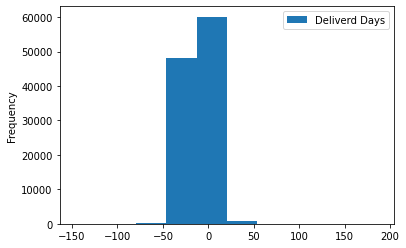

In [16]:
data_cat[['Deliverd Days']].plot.hist()

In [17]:
data_cat[['Deliverd Days']] = pd.cut(data_cat['Deliverd Days'], bins=[-100,-20,-1,1,20,100], 
labels=["super_fast", "fast", "on_time", "late", "superlate"])

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [19]:
data_cat = data_cat.apply(le.fit_transform)

In [20]:
data_cat.isna().sum()

product_category_name    0
Deliverd Days            0
dtype: int64

In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_num=pd.DataFrame(ss.fit_transform(data_num), columns=data_num.columns)


In [22]:
data_num.reset_index(inplace=True)
data_num

,index,price,freight_value,review_score
0,0,0.027814,0.121550,-0.050043
1,1,-0.038204,0.313815,-2.259774
2,2,-0.038204,0.313815,-2.259774
3,3,0.027814,-0.276984,-0.786620
4,4,-0.071214,0.676061,-0.050043
...,...,...,...,...
109297,109297,8.967924,1.212746,-0.050043
109298,109298,0.142852,-0.286534,0.686534
109299,109299,-0.385299,0.147016,0.686534
109300,109300,0.088277,4.360280,0.686534


In [23]:
data_cat.reset_index(inplace=True)
data_cat

,index,product_category_name,Deliverd Days
0,0,55,0
1,1,55,3
2,2,55,3
3,3,55,0
4,4,55,3
...,...,...,...
109297,113315,11,3
109298,113316,10,0
109299,113318,63,0
109300,113320,40,0


In [33]:
data_final = pd.concat([data_num, data_cat], axis=1, ignore_index=True)

In [34]:
data_final.head()

,0,1,2,3,4,5,6
0,0,0.027814,0.121550,-0.050043,0,55,0
1,1,-0.038204,0.313815,-2.259774,1,55,3
2,2,-0.038204,0.313815,-2.259774,2,55,3
3,3,0.027814,-0.276984,-0.786620,3,55,0
4,4,-0.071214,0.676061,-0.050043,4,55,3


In [35]:
data_final = pd.DataFrame(data_final.drop([0,4], axis=1))
             

In [36]:
data_final.head()

,1,2,3,5,6
0,0.027814,0.121550,-0.050043,55,0
1,-0.038204,0.313815,-2.259774,55,3
2,-0.038204,0.313815,-2.259774,55,3
3,0.027814,-0.276984,-0.786620,55,0
4,-0.071214,0.676061,-0.050043,55,3


In [37]:
X = data_final.drop([6], axis=1)
y = data_final[6]

In [38]:
y

0         0
1         3
2         3
3         0
4         3
         ..
109297    3
109298    0
109299    0
109300    0
109301    1
Name: 6, Length: 109302, dtype: int64

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.3, stratify=y)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [56]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
acc = accuracy_score(y_test, pred)
ps = precision_score(y_test, pred,average='weighted')
rc = recall_score(y_test, pred,average='weighted')
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)

Precision 0.612917840366748 
 Recall 0.7439541337562136 
 Accuracy 0.7439541337562136 

 Confusion Matrix



array([[24336,    68,     0,    53,     0,     0],
       [ 1575,    39,     0,     3,     0,     0],
       [  699,     3,     0,     7,     0,     0],
       [ 5702,    27,     0,    20,     0,     0],
       [  237,     8,     0,     0,     0,     0],
       [   14,     0,     0,     0,     0,     0]])

In [50]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)
acc = accuracy_score(y_test, pred)
ps = precision_score(y_test, pred,average='weighted')
rc = recall_score(y_test, pred,average='weighted')
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)

TypeError: __init__() got an unexpected keyword argument 'probability'

In [44]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
acc = accuracy_score(y_test, pred)
ps = precision_score(y_test, pred,average='weighted')
rc = recall_score(y_test, pred,average='weighted')
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)

Precision 0.667451269114504 
 Recall 0.7280351315909853 
 Accuracy 0.7280351315909853 

 Confusion Matrix



array([[22503,   359,    60,  1515,    20,     0],
       [ 1172,   330,     7,    98,    10,     0],
       [  613,    19,    25,    52,     0,     0],
       [ 4600,   120,    13,  1011,     5,     0],
       [  188,    36,     3,    14,     4,     0],
       [   12,     1,     0,     1,     0,     0]])

In [54]:
svc = SVC(max_iter=50, probability=True)
svc.fit(x_train, y_train)
pred = svc.predict(x_test)
acc = accuracy_score(y_test, pred)
ps = precision_score(y_test, pred,average='weighted')
rc = recall_score(y_test, pred,average='weighted')
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)

Precision 0.5770489400628833 
 Recall 0.05275837882345766 
 Accuracy 0.05275837882345766 

 Confusion Matrix



array([[    8,  1259,  6067,  5589, 11534,     0],
       [    1,   144,   417,   326,   729,     0],
       [    0,    36,   202,   150,   321,     0],
       [    1,   325,  1549,  1266,  2608,     0],
       [    1,    25,    61,    48,   110,     0],
       [    0,     2,     4,     2,     6,     0]])

In [55]:
from sklearn.ensemble import VotingClassifier

vt = VotingClassifier([("Logistic Regression", lr),
                      ("Naive Bayes", gnb), ("SVC", svc)], voting="soft", n_jobs=-1)

vt.fit(x_train, y_train)
pred = vt.predict(x_test)
acc = accuracy_score(y_test, pred)
ps = precision_score(y_test, pred,average='weighted')
rc = recall_score(y_test, pred,average='weighted')
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)

Precision 0.6208233134668276 
 Recall 0.7436491720289103 
 Accuracy 0.7436491720289103 

 Confusion Matrix



array([[24316,    51,     0,    82,     8,     0],
       [ 1577,    34,     0,     4,     2,     0],
       [  702,     4,     0,     3,     0,     0],
       [ 5687,    23,     0,    35,     4,     0],
       [  236,     9,     0,     0,     0,     0],
       [   14,     0,     0,     0,     0,     0]])

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#X = X.to_numpy()
#y = y.to_numpy()
precision_scores = []
recall_scores = []
accuracy_scores = []
predictions = []
data_y = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    precision_scores.append(
        precision_score(vt.fit(X_train, y_train).predict(X_test), y_test, average='weighted')
    )
    recall_scores.append(
        recall_score(vt.fit(X_train, y_train).predict(X_test), y_test, average='weighted')
    )
    accuracy_scores.append(
        accuracy_score(vt.fit(X_train, y_train).predict(X_test), y_test)
    )

    
acc = np.mean(accuracy_scores)
ps = np.mean(precision_scores)
rc = np.mean(recall_scores)
print("Precision", ps, "\n", "Recall", rc, "\n", "Accuracy", acc, "\n\n", "Confusion Matrix\n")
confusion_matrix(y_test, pred)